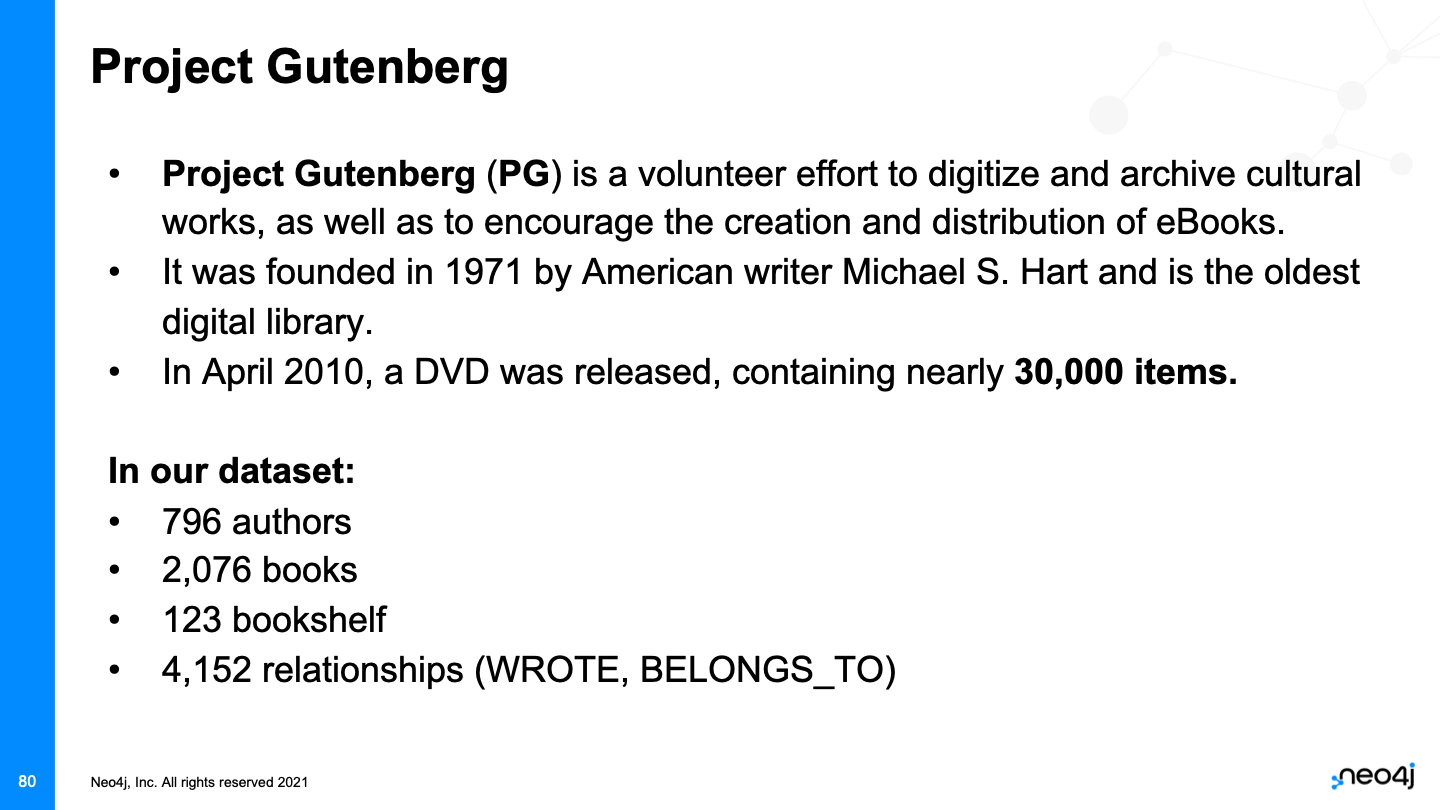

Install GDS

In [ ]:
!pip install graphdatascience

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 2.3 MB/s 
     |████████████████████████████████| 95 kB 2.0 MB/s 
  Created wheel for neo4j: filename=neo4j-4.4.5-py3-none-any.whl size=123291 sha256=1c2aeafee26a647f65c55af74796e3e73a028065a014e50f9da42642d860e413
  Stored in directory: /root/.cache/pip/wheels/73/62/2d/6532ffe9b1fdc65f04e7461279cda78fccaa67cf3c706e6e3d
Successfully built neo4j


Getting our credentials - from Sandbox in this example

In [ ]:
bolt = "bolt://3.239.217.237:7687"
auth = ("neo4j", "apprenticeship-resistance-variation")

Instantiate the new Python GDS Client

In [ ]:
import pandas as pd
from IPython.display import display

from graphdatascience import GraphDataScience

gds = GraphDataScience(bolt, auth=auth)

When using Neo4j Sandbox make sure to disable the Timeout:


In [ ]:
gds.run_cypher("""CALL dbms.setConfigValue('dbms.transaction.timeout','0');""")

""


Load dataset

In [ ]:
load = """LOAD CSV WITH HEADERS FROM 'https://raw.githubusercontent.com/marcobessi/gutenberg/main/gutenberg2.csv' AS line
CREATE (b:Book {title: line.Title, id: line.bookID, embedding: toFloatList(apoc.convert.toList(split(line.embedding,','))), bookshelf:line.Bookshelves})
MERGE (a:Author {id: line.Author})
CREATE (a)-[:WROTE]->(b)
RETURN count(b) as books
"""
gds.run_cypher(load)

,books
0,2076


Create new label Bookshelf

In [ ]:
create_bookshelf = """MATCH (b:Book)
MERGE (bs:Bookshelf {name:b.bookshelf})
CREATE (b)-[:BELONGS_TO]->(bs)"""

gds.run_cypher(create_bookshelf)

""


Splitting property id of Author

In [ ]:
split_id = """MATCH (a:Author)
SET a.surname = trim(split(a.id, ",")[0]),
    a.name = trim(split(a.id, ",")[1]),
    a.year = trim(split(a.id, ",")[2])"""

gds.run_cypher(split_id)

""


Convert Bookshelves string to numerical

In [ ]:
convert_bookshelf = """MATCH (b:Book)
WITH collect(DISTINCT b.bookshelf) as listBookshelves
WITH listBookshelves, size(listBookshelves) AS sizeListBookshelves
WITH listBookshelves, range(1, sizeListBookshelves) AS rangeBookshelves
WITH apoc.map.fromLists(listBookshelves, rangeBookshelves) AS mapBookshelves
MATCH (b:Book)
SET b.bookshelf_class_id = mapBookshelves[b.bookshelf];"""

gds.run_cypher(convert_bookshelf)

""


# Time to start the GDS Engines


**Preparation**: Creating SAME_AUTHOR relationships

In [ ]:
same_author = """MATCH (b1:Book)<-[w1:WROTE]-(a:Author)-[w2:WROTE]->(b2:Book)
WHERE id(b1)<id(b2)
MERGE (b1)-[:SAME_AUTHOR]->(b2)"""

gds.run_cypher(same_author)

""


**Preparation**: Considering only the Top10 bookshelves

In [ ]:
top10 = """MATCH (b:Bookshelf)<-[]-(bk:Book)
WITH b.name as bs, count (bk) as n ORDER BY n DESC
WITH collect(bs) as bsList
WITH [bsList[0],bsList[1],bsList[2],bsList[3],bsList[4],bsList[5],bsList[6],bsList[7],bsList[8],bsList[9]] as bsTop
MATCH (bk:Book)
WHERE bk.bookshelf IN bsTop
SET bk.top=1"""

gds.run_cypher(top10)

""


Calculate embeddings for SAME_AUTHOR

In [ ]:
query_proj = """CALL gds.graph.project(
  'fastrp-sameauthor',
  { Book: {
    label: 'Book',
    properties: {
      bookshelf_class_id: { property: 'bookshelf_class_id', defaultValue: 0 },
      top: { property: 'top', defaultValue: 0 },
      embedding: { property: 'embedding', defaultValue: null } } } },
  { SAME_AUTHOR: { orientation: 'UNDIRECTED' } }
)"""

gds.run_cypher(query_proj)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Book': {'label': 'Book', 'properties': {'boo...","{'SAME_AUTHOR': {'orientation': 'UNDIRECTED', ...",fastrp-sameauthor,2076,111576,2702


In [ ]:
query_subG_top10 = """CALL gds.beta.graph.project.subgraph('fastrp-sameauthor-top10', 'fastrp-sameauthor', 'n:Book AND n.top = 1', '*')
    YIELD graphName, fromGraphName, nodeCount, relationshipCount"""

res_top10 = gds.run_cypher(query_subG_top10)
df_res_top10 = pd.DataFrame.from_dict(res_top10)
display(df_res_top10)

,graphName,fromGraphName,nodeCount,relationshipCount
0,fastrp-sameauthor-top10,fastrp-sameauthor,1148,44712


In [ ]:
fastrp_write = """CALL gds.fastRP.write(
  'fastrp-sameauthor-top10',
  {
    relationshipTypes:['SAME_AUTHOR'],
    featureProperties: ['embedding'],
    propertyRatio: 0.5,
    embeddingDimension: 768,
    randomSeed: 42,
    writeProperty: 'fastrp_embedding'
  }
)
YIELD nodePropertiesWritten"""

gds.run_cypher(fastrp_write)

,nodePropertiesWritten
0,1148


**Computing the Test/Train split.** We will slice of 20% of the graph as test graph and make predictions on, such to check the accuracy of the model on unseen data

In [ ]:
query_train = """MATCH (b:Book) WHERE b.top=1 WITH collect(ID(b)) as books
WITH apoc.coll.randomItems(books, toInteger(0.8 * size(books))) as trainBooks
UNWIND trainBooks as trainBook
MATCH (b:Book) WHERE id(b) = trainBook
SET b.is_train_data = 1"""

gds.run_cypher(query_train)

""


In [ ]:
query_test = """MATCH (b:Book)
WHERE b.top=1 AND b.is_train_data IS NULL
SET b.is_train_data = 0"""

gds.run_cypher(query_test)

""


Projection

In [ ]:
query_proj = """CALL gds.graph.project(
  'gutenberg-graph',
  { Book: {
    label: 'Book',
    properties: {
      bookshelf_class_id: { property: 'bookshelf_class_id', defaultValue: 0 },
      fastrp_embedding: { property: 'fastrp_embedding', defaultValue: null },
      embedding: { property: 'embedding', defaultValue: null },
      top: { property: 'top', defaultValue: 0 },
      is_train_data: { property:'is_train_data', defaultValue: 0} } } },
  { SAME_AUTHOR: { orientation: 'UNDIRECTED' } }
)"""

gds.run_cypher(query_proj)
G = gds.graph.get("gutenberg-graph")

The GDS client allows to determine the Graph as an object with a bunch of methods developed for it


In [ ]:
print("Properties of the nodes are: ", G.node_properties('Book'), ", total number of nodes is: ", G.node_count(), ", and size of the graph is ",  G.size_in_bytes())

Properties of the nodes are:  ['bookshelf_class_id', 'top', 'embedding', 'fastrp_embedding', 'is_train_data'] , total number of nodes is:  2076 , and size of the graph is  13077504


Creating two subgraphs from the main graph in memory: a train and test graph






In [ ]:
query_subG_train = """CALL gds.beta.graph.project.subgraph('gutenberg-train-graph', 'gutenberg-graph', 'n:Book AND n.top=1 AND n.is_train_data = 1', '*')
    YIELD graphName, fromGraphName, nodeCount, relationshipCount"""

res_train = gds.run_cypher(query_subG_train)
df_res_train = pd.DataFrame.from_dict(res_train)
display(df_res_train)

,graphName,fromGraphName,nodeCount,relationshipCount
0,gutenberg-train-graph,gutenberg-graph,918,28872


In [ ]:
query_subG_test = """CALL gds.beta.graph.project.subgraph('gutenberg-test-graph', 'gutenberg-graph', 'n:Book AND n.top=1 AND n.is_train_data = 0', '*')
    YIELD graphName, fromGraphName, nodeCount, relationshipCount"""

res_test = gds.run_cypher(query_subG_test)
df_res_test = pd.DataFrame.from_dict(res_test)
display(df_res_test)

,graphName,fromGraphName,nodeCount,relationshipCount
0,gutenberg-test-graph,gutenberg-graph,230,1666


Quick check to see what we have projected in memory so far

In [ ]:
res_list = gds.run_cypher(""" CALL gds.graph.list()""")
df_res_list = pd.DataFrame.from_dict(res_list)
display(df_res_list)

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema


#Create Pipeline

Create new pipeline

In [ ]:
gds.beta.pipeline.nodeClassification.create('pipe-nc-graph')

(<graphdatascience.pipeline.nc_training_pipeline.NCTrainingPipeline at 0x7f8037457fd0>,
 name                                                  pipe-nc-graph
 nodePropertySteps                                                []
 featureProperties                                                []
 splitConfig             {'testFraction': 0.3, 'validationFolds': 3}
 parameterSpace       {'RandomForest': [], 'LogisticRegression': []}
 Name: 0, dtype: object)

In [ ]:
_pipe = gds.pipeline.get("pipe-nc-graph")
_pipe

Selecting the features to be used in the training

In [ ]:
_pipe.selectFeatures(['fastrp_embedding'])

name                                                  pipe-nc-graph
nodePropertySteps                                                []
featureProperties                                [fastrp_embedding]
splitConfig             {'testFraction': 0.3, 'validationFolds': 3}
parameterSpace       {'RandomForest': [], 'LogisticRegression': []}
Name: 0, dtype: object

Configuring the splitting is optional, and if omitted, splitting will be done using default settings. The splitting configuration of a pipeline can be inspected by using gds.beta.model.list and possibly only yielding splitConfig.



In [ ]:
configure_split = """CALL gds.beta.pipeline.nodeClassification.configureSplit('pipe-nc-graph', {
      testFraction: 0.3,
      validationFolds: 3
    })
    YIELD splitConfig"""
gds.run_cypher(configure_split)

,splitConfig
0,"{'testFraction': 0.3, 'validationFolds': 3}"


A pipeline contains a collection of configurations for model candidates which is initially empty. This collection is called the parameter space. One or more model configurations must be added to the parameter space of the training pipeline, using one of the following procedures:

At least one model candidate must be added to the pipeline before training it.



In [ ]:
#_pipe.addLogisticRegression(tolerance=0.001, maxEpochs=100, penalty=0.0, batchSize=32)
#_pipe.addLogisticRegression(tolerance=0.001, maxEpochs=150, penalty=0.05, batchSize=64)
_pipe.addLogisticRegression(tolerance=0.001, maxEpochs=200, penalty=0.01, batchSize=128)
#_pipe.addLogisticRegression(tolerance=0.001, maxEpochs=200, penalty=0.005, batchSize=64)
#_pipe.addLogisticRegression(tolerance=0.001, maxEpochs=400, penalty=0.0625, batchSize=256)
#_pipe.addLogisticRegression(tolerance=0.001, maxEpochs=250, penalty=0.1, batchSize=512)
#_pipe.addLogisticRegression(tolerance=0.001, maxEpochs=400, penalty=0.01, batchSize=512)

name                                                     pipe-nc-graph
nodePropertySteps                                                   []
featureProperties                                   [fastrp_embedding]
splitConfig                {'testFraction': 0.3, 'validationFolds': 3}
parameterSpace       {'RandomForest': [], 'LogisticRegression': [{'...
Name: 0, dtype: object

In [ ]:
G = 'gutenberg-train-graph'

train_query = """CALL gds.beta.pipeline.nodeClassification.train('gutenberg-train-graph', {
  pipeline: 'pipe-nc-graph',
  nodeLabels: ['Book'],
  modelName: 'GutenbergModelNC-Graph',
  targetProperty: 'bookshelf_class_id',
  metrics: ['F1_WEIGHTED','ACCURACY']
}) """

gds.run_cypher(train_query)

,modelSelectionStats,trainMillis,modelInfo,configuration
0,{'validationStats': {'F1_WEIGHTED': [{'min': 0...,107108,"{'modelName': 'GutenbergModelNC-Graph', 'class...","{'pipeline': 'pipe-nc-graph', 'graphName': 'gu..."


In [ ]:
query_predict = """CALL gds.beta.pipeline.nodeClassification.predict.mutate('gutenberg-test-graph', {
      nodeLabels: ['Book'],
      modelName: 'GutenbergModelNC-Graph',
      mutateProperty: 'predicted_bookshelf_class_id'
    })"""

res_predict = gds.run_cypher(query_predict)
print(res_predict)

   nodePropertiesWritten  mutateMillis  postProcessingMillis  \
0                    230             2                     0   

   preProcessingMillis  computeMillis  \
0                    2             50   

                                       configuration  
0  {'graphName': 'gutenberg-test-graph', 'modelNa...  


In [ ]:
query_writeNode = """CALL gds.graph.writeNodeProperties(
      'gutenberg-test-graph',
      ['predicted_bookshelf_class_id'],
      ['Book']
    )"""

gds.run_cypher(query_writeNode)

,writeMillis,graphName,nodeProperties,propertiesWritten
0,94,gutenberg-test-graph,[predicted_bookshelf_class_id],230


In [ ]:
query_check = """MATCH (b:Book)
WHERE b.is_train_data = 0
WITH count(b) AS nbBooks
MATCH (b:Book)
WHERE b.is_train_data = 0
AND b.bookshelf_class_id = b.predicted_bookshelf_class_id
RETURN toFloat(count(b)) / nbBooks AS ratio"""

q_check = gds.run_cypher(query_check)

df_q_check = pd.DataFrame.from_dict(q_check)
display(df_q_check)

,ratio
0,0.8


#Confusion matrix and Classification report

Confusuion matrix

In [ ]:
# Importing the dependancies
from sklearn import metrics

results = """MATCH (b:Book)
WHERE b.is_train_data = 0 AND b.top = 1
WITH collect(distinct [b.bookshelf_class_id, b.bookshelf]) as possible_classes
RETURN possible_classes"""
q_results = gds.run_cypher(results)

display(q_results['possible_classes'][0])

[[1, "Children's Literature"],
 [10, 'Bestsellers, American, 1895-1923'],
 [22, "Children's Fiction"],
 [23, 'US Civil War'],
 [5, 'Science Fiction'],
 [31, "Children's Book Series"],
 [4, 'Historical Fiction'],
 [75, 'The Mirror of Literature, Amusement, and Instruction'],
 [79, "Children's Picture Books"],
 [78, 'Punch']]

In [ ]:
predictions = """MATCH (b:Book)
WHERE b.is_train_data = 0 AND b.top = 1
WITH collect(b.bookshelf_class_id) as original, collect(b.predicted_bookshelf_class_id) as predicted, collect(b.bookshelf) as names
RETURN original, predicted, names"""

q_predictions = gds.run_cypher(predictions)

# Predicted values
y_pred = q_predictions['predicted'][0]
# Actual values
y_act = q_predictions['original'][0]

print(metrics.confusion_matrix(y_act, y_pred, labels=[5, 10, 22, 31, 1, 23, 4, 75, 79, 78]))

[[46  0  0  0  0  0  0  0  0  0]
 [10 15  0  1  0  0  0  0  0  0]
 [ 0  0 31  0  0  0  0  0  0  0]
 [ 2  0  4 24  0  0  0  0  0  0]
 [ 3  2  0  0  3  0  0  0  1  0]
 [ 4  0  1  0  0  8  0  0  0  0]
 [ 0  0  0  1  0  0 19  0  0  0]
 [ 0  0  0  0  0  0  0 20  0  0]
 [ 3  0  0  0  0  0  0  0 18  0]
 [ 0  0  0  0  0  0  0 14  0  0]]


In [ ]:
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_act, y_pred, labels=[5, 10, 22, 31, 1, 23, 4, 75, 79, 78]))

              precision    recall  f1-score   support

           5       0.68      1.00      0.81        46
          10       0.88      0.58      0.70        26
          22       0.86      1.00      0.93        31
          31       0.92      0.80      0.86        30
           1       1.00      0.33      0.50         9
          23       1.00      0.62      0.76        13
           4       1.00      0.95      0.97        20
          75       0.59      1.00      0.74        20
          79       0.95      0.86      0.90        21
          78       0.00      0.00      0.00        14

    accuracy                           0.80       230
   macro avg       0.79      0.71      0.72       230
weighted avg       0.79      0.80      0.77       230



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
differences = """MATCH (b:Book)
WHERE b.is_train_data = 0 AND b.top = 1 AND b.bookshelf_class_id <> b.predicted_bookshelf_class_id
CALL{ WITH b
    MATCH (x:Book{bookshelf_class_id:b.predicted_bookshelf_class_id})
    RETURN DISTINCT x.bookshelf as predicted_name
}
RETURN b.bookshelf_class_id as real, b.bookshelf as real_name, b.predicted_bookshelf_class_id as predicted, predicted_name, count(b) as n_wrong_classifications
ORDER BY real, predicted"""

q_differences = gds.run_cypher(differences)
display(q_differences)

,real,real_name,predicted,predicted_name,n_wrong_classifications
0,1,Children's Literature,5,Science Fiction,3
1,1,Children's Literature,10,"Bestsellers, American, 1895-1923",2
2,1,Children's Literature,79,Children's Picture Books,1
3,4,Historical Fiction,31,Children's Book Series,1
4,10,"Bestsellers, American, 1895-1923",5,Science Fiction,10
5,10,"Bestsellers, American, 1895-1923",31,Children's Book Series,1
6,23,US Civil War,5,Science Fiction,4
7,23,US Civil War,22,Children's Fiction,1
8,31,Children's Book Series,5,Science Fiction,2
9,31,Children's Book Series,22,Children's Fiction,4


# Clean up after the party

Dropping projections

In [ ]:
query_d0 = """CALL gds.graph.drop('fastrp-sameauthor')"""
gds.run_cypher(query_d0)
query_d00 = """CALL gds.graph.drop('fastrp-sameauthor-top10')"""
gds.run_cypher(query_d00)

ClientError: ignored

In [ ]:
query_d1 = """CALL gds.graph.drop('gutenberg-graph')"""
gds.run_cypher(query_d1)
query_d2 = """CALL gds.graph.drop('gutenberg-train-graph')"""
gds.run_cypher(query_d2)
query_d3 = """CALL gds.graph.drop('gutenberg-test-graph')"""
gds.run_cypher(query_d3)

ClientError: ignored

Dropping pipe and model

In [ ]:
drop_pipe = """CALL gds.beta.pipeline.drop('pipe-nc-graph')"""
gds.run_cypher(drop_pipe)
drop_model = """CALL gds.beta.model.drop('GutenbergModelNC-Graph')"""
gds.run_cypher(drop_model)

ClientError: ignored

Dropping dataset

In [ ]:
drop_dataset = """MATCH (n) DETACH DELETE n"""
gds.run_cypher(drop_dataset)

""
